In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
import pandas as pd
import math
import tensorflow as tf
from lib.pinn import PINN
from lib.network import Network
import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.set_printoptions(precision=3, suppress=True) 

In [18]:
# number of test samples
num_test_samples = 10

# system parameters
from parameters import p

In [4]:
network = Network.build(**p)

pinn = PINN(network, **p).build(**p)
pinn.compile(optimizer='adam', loss='mse')
if pathlib.Path("weights.h5").exists():
    pinn.load_weights("weights.h5")

In [13]:
epochs=1000
n_train_samples = 1000

max_d = p["max_dim"][0:p["dim"]+1]

x_train = np.random.rand(n_train_samples, 1+p["dim"]) * max_d
x_train_left = np.random.rand(n_train_samples, 1+p["dim"]) * max_d
x_train_left[:,1] = 0
x_train_right = np.random.rand(n_train_samples, 1+p["dim"]) * max_d
x_train_right[:,1] = 0
x=[x_train, x_train_left, x_train_right]

y = [np.zeros((n_train_samples, 1))] * len(pinn.output_shape)


In [14]:
pinn.fit(x=x, y=y, epochs=epochs)
# pinn.save_weights('weights.h5')


Epoch 1/1000
32/32 [==============================] - 0s 3ms/step - loss: 4.1927 - tf.__operators__.add_loss: 1.7535e-04 - tf.__operators__.add_1_loss: 0.1142 - tf.__operators__.add_4_loss: 4.0541 - gradient_layer_loss: 2.1535e-04 - tf.math.subtract_1_loss: 9.2384e-04 - gradient_layer_1_loss: 0.0090 - tf.math.subtract_2_loss: 0.0022 - tf.math.subtract_3_loss: 8.3967e-04 - gradient_layer_2_loss: 0.0090 - tf.math.subtract_4_loss: 0.0020     
Epoch 2/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.5276 - tf.__operators__.add_loss: 1.6556e-04 - tf.__operators__.add_1_loss: 0.1360 - tf.__operators__.add_4_loss: 1.3520 - gradient_layer_loss: 1.3438e-04 - tf.math.subtract_1_loss: 0.0014 - gradient_layer_1_loss: 0.0162 - tf.math.subtract_2_loss: 0.0022 - tf.math.subtract_3_loss: 0.0015 - gradient_layer_2_loss: 0.0162 - tf.math.subtract_4_loss: 0.0019
Epoch 3/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.7808 - tf.__operators__.add_loss: 1.3884e-04 - tf

In [15]:
num_test_samples = 30
dims = np.linspace(np.zeros(p["dim"]+1), p["max_dim"], num_test_samples).T
dims = np.split(dims.flatten(), p["dim"]+1)
mdims = np.meshgrid(*dims)
txyz = np.stack([mdim.flatten() for mdim in mdims], axis=-1)

In [16]:
c, v, Fi = network.predict(txyz, batch_size=num_test_samples)

900/900 [==============================] - 1s 572us/step


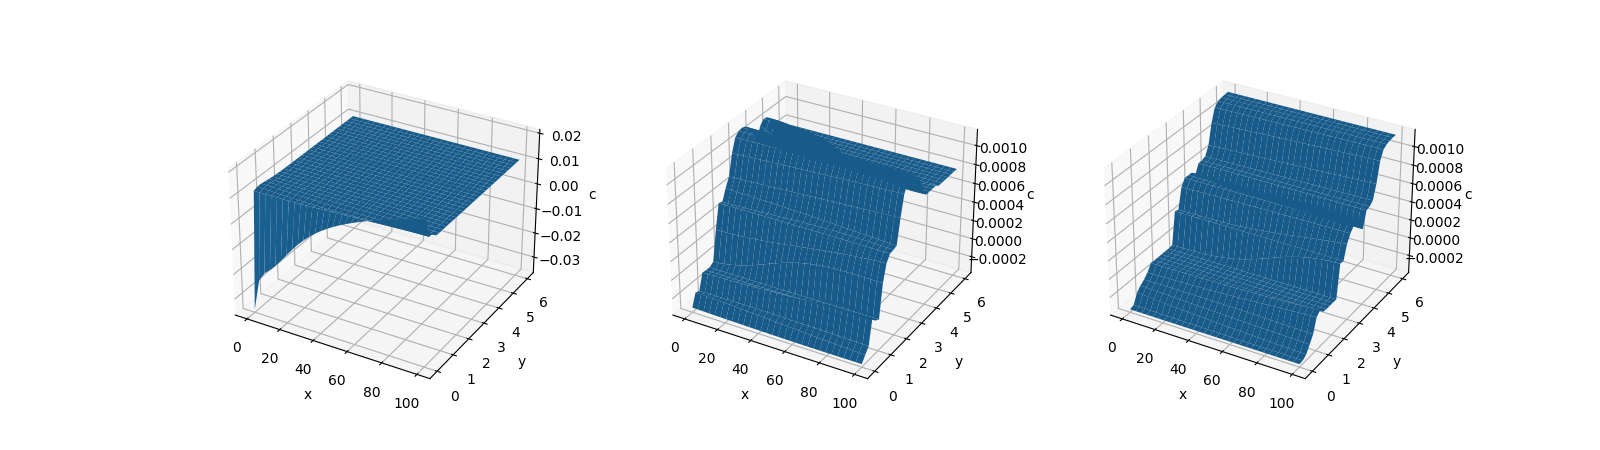

In [17]:
c = c.reshape(mdims[0].shape)
time_t = 20
fig = plt.figure(figsize=(16, 4.5))

ax1 = fig.add_subplot(131,projection="3d")
# ax1.plot(dims[1], c[(0, slice(None),) + tuple(int(d/2) for d in p["max_dim"][2:])])
ax1.plot_surface(*np.meshgrid(dims[1], dims[2]), c[0])
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("c")

ax2 = fig.add_subplot(132,projection="3d")
# ax1.plot(dims[1], c[(0, slice(None),) + tuple(int(d/2) for d in p["max_dim"][2:])])
ax2.plot_surface(*np.meshgrid(dims[1], dims[2]), c[10])
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("c")

ax3 = fig.add_subplot(133,projection="3d")
# ax1.plot(dims[1], c[(0, slice(None),) + tuple(int(d/2) for d in p["max_dim"][2:])])
ax3.plot_surface(*np.meshgrid(dims[1], dims[2]), c[20])
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_zlabel("c")

# ax2 = fig.add_subplot(132)
# xx, yy = np.meshgrid(x_flat, y_flat)
# v = v.reshape(t.shape + (3,))
# v_xy = v[time_t, :, :, int(p["max_z"]/2), 0:2]
# ax2.quiver(xx, yy, v_xy[..., 0], v_xy[..., 1])

# ax3 = fig.add_subplot(133)
# ax3.plot(x_flat, v[time_t, :, int(p["max_y"]/2), int(p["max_z"]/2), 0])

plt.show()


In [ ]:
network(np.array([[p["max_t"], p["max_x"], p["max_y"], p["max_z"]]]))

In [77]:
np.meshgrid(np.zeros(2), np.zeros(3))

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
n_test_samples = 2
max_d = np.array([p["max_t"], p["max_x"], p["max_y"], p["max_z"]])
x_train = np.random.rand(n_test_samples, 4) * max_d
x_train_left = np.random.rand(n_test_samples, 4) * max_d
x_train_left[:,1] = 0
x_train_right = np.random.rand(n_test_samples, 4) * max_d
x_train_right[:,1] = 0
x=[x_train, x_train_left, x_train_right]
for i, xx in enumerate(pinn(x)):
    print(i, ":", xx.shape)
